In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import cv2

In [3]:
import tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D, Input
from tensorflow.keras.utils import to_categorical

### Load data and preprocessing

In [4]:
def preprocess_mnist(images, target_size = (224, 224)):
  resized_images = np.zeros((images.shape[0], *target_size, 3), dtype=np.float32)
  for i, img in enumerate(images):
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
    resized_img = np.expand_dims(resized_img, axis = -1) / 255.0
    resized_images[i] = resized_img

  return resized_images


In [5]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train_resized = preprocess_mnist(x_train[0 : 3000])
x_test_resized = preprocess_mnist(x_test[0 : 3000]);

y_train = y_train[0 : 3000]
y_test = y_test[0 : 3000]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
def get_feature_extractor():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  x = GlobalAvgPool2D()(base_model.output)
  model = Model(inputs = base_model.inputs, outputs = x)
  return model

In [7]:
feature_extractor = get_feature_extractor()
features_before = feature_extractor.predict(x_test_resized, batch_size = 32)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step


### After fine tuning

In [8]:
def get_finetuned_model():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  base_model.trainable = True

  x = GlobalAvgPool2D()(base_model.output)
  x = Dense(32, activation = 'relu')(x)
  output = Dense(10, activation = 'softmax')(x)

  model = Model(inputs = base_model.input, outputs = output)
  return model


In [9]:
fineTuned_model = get_finetuned_model()
fineTuned_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
fineTuned_model.fit(x_train_resized, y_train, epochs = 5, batch_size = 32)

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 106s 505ms/step - accuracy: 0.7497 - loss: 0.8535
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - accuracy: 0.9469 - loss: 0.1939
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9539 - loss: 0.1513
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.9800 - loss: 0.0732
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.9805 - loss: 0.0706


In [10]:
feature_model_after = Model(inputs=fineTuned_model.input, outputs = fineTuned_model.layers[-3].output)
features_after = feature_model_after.predict(x_test_resized, batch_size= 32)

94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step


In [11]:
def plot_2d(features, labels, title, reducer):
  reduced = reducer.fit_transform(features)
  plt.figure(figsize=(6, 5))
  scatter = plt.scatter(reduced[:, 0], reduced[:, -1], c=labels, cmap='tab10', s=10)
  plt.legend(*scatter.legend_elements(), title="Digits", loc="best", fontsize=8)
  plt.title(title)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

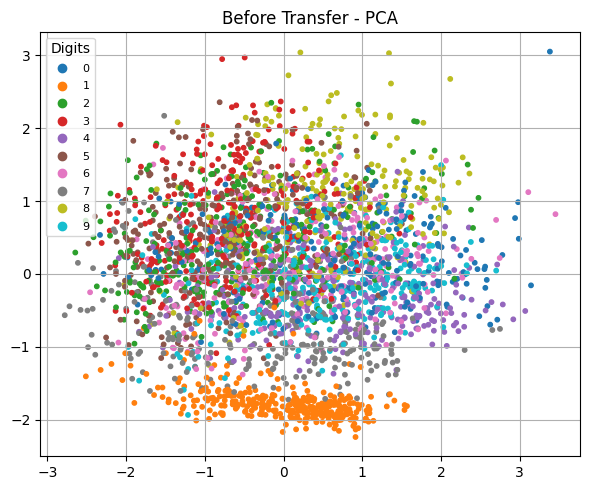

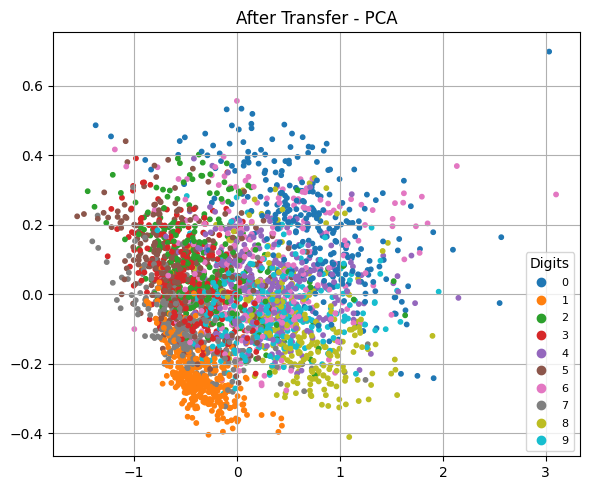

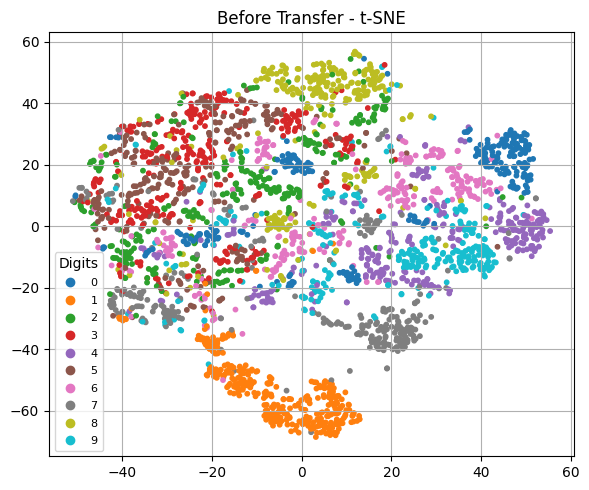

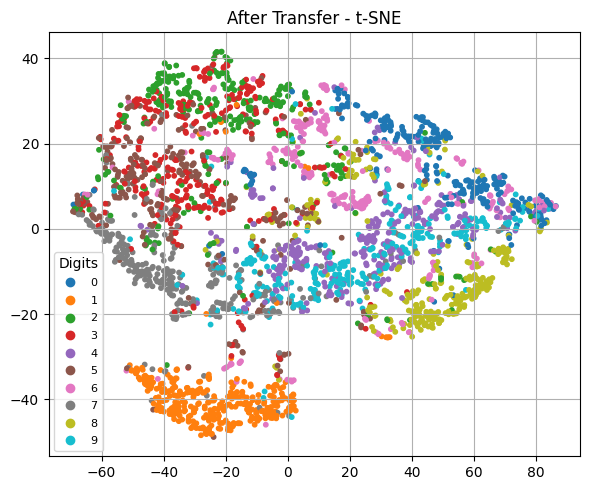

In [12]:
plot_2d(features_before, y_test, "Before Transfer - PCA", PCA(n_components=2))
plot_2d(features_after, y_test,  "After Transfer - PCA", PCA(n_components=2))

plot_2d(features_before, y_test, "Before Transfer - t-SNE", TSNE(n_components=2, perplexity=30, random_state=42))
plot_2d(features_after, y_test,  "After Transfer - t-SNE", TSNE(n_components=2, perplexity=30, random_state=42))


In [13]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.utils import to_categorical

# # --------------------------
# # Load & Preprocess MNIST
# # --------------------------
# def preprocess_mnist():
#     (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
#     x_train = x_train[:2000]  # subset for speed
#     y_train = y_train[:2000]

#     x_train = np.stack([x_train]*3, axis=-1)  # make 3-channel
#     x_train = tf.image.resize(x_train, [224, 224]).numpy()
#     x_train = x_train / 255.0
#     return x_train, y_train

# x_train, y_train = preprocess_mnist()

# # --------------------------
# # Create Feature Extractor (ResNet50 base)
# # --------------------------
# def get_feature_extractor():
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     x = GlobalAveragePooling2D()(base_model.output)
#     model = Model(inputs=base_model.input, outputs=x)
#     return model

# feature_extractor = get_feature_extractor()

# # --------------------------
# # Extract Features (Before Transfer)
# # --------------------------
# features_before = feature_extractor.predict(x_train, batch_size=32)

# # --------------------------
# # Fine-tune ResNet on MNIST
# # --------------------------
# def get_finetuned_model():
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     base_model.trainable = True  # fine-tune entire model

#     x = GlobalAveragePooling2D()(base_model.output)
#     output = Dense(10, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=output)
#     return model

# ft_model = get_finetuned_model()
# ft_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# ft_model.fit(x_train, y_train, epochs=1, batch_size=32)  # 1 epoch just to illustrate

# # --------------------------
# # Extract Features (After Transfer)
# # --------------------------
# feature_model_after = Model(inputs=ft_model.input, outputs=ft_model.layers[-2].output)  # extract before final Dense
# features_after = feature_model_after.predict(x_train, batch_size=32)

# # --------------------------
# # Plotting Function
# # --------------------------
# def plot_2d(features, labels, title, reducer):
#     reduced = reducer.fit_transform(features)
#     plt.figure(figsize=(6,5))
#     scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=10)
#     plt.legend(*scatter.legend_elements(), title="Digits", loc="best", fontsize=8)
#     plt.title(title)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # --------------------------
# # Dimensionality Reduction & Plot
# # --------------------------
# plot_2d(features_before, y_train, "Before Transfer - PCA", PCA(n_components=2))
# plot_2d(features_after, y_train,  "After Transfer - PCA", PCA(n_components=2))

# plot_2d(features_before, y_train, "Before Transfer - t-SNE", TSNE(n_components=2, perplexity=30, random_state=42))
# plot_2d(features_after, y_train,  "After Transfer - t-SNE", TSNE(n_components=2, perplexity=30, random_state=42))

# plot_2d(features_before, y_train, "Before Transfer - UMAP", umap.UMAP(n_components=2, random_state=42))
# plot_2d(features_after, y_train,  "After Transfer - UMAP", umap.UMAP(n_components=2, random_state=42))
